In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from behav import plotting, utils, loading

import seaborn as sns
sns.set_style("whitegrid")

data_path = '/mnt/cube/RawData/Zog/'

subjects = (
    'B1178',
    'B1186',
    'B1049',
    'B1188',
)

## Loads Data

In [2]:
%%time
behav_data = loading.load_data_pandas(subjects, data_path)

CPU times: user 12.7 s, sys: 1.34 s, total: 14 s
Wall time: 15.4 s


## plot performance over past two weeks in calendar

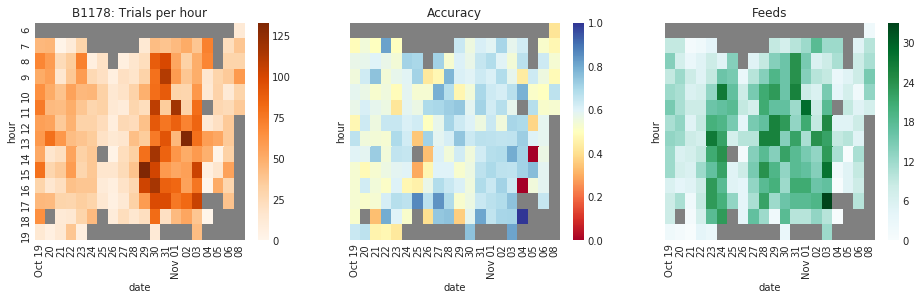

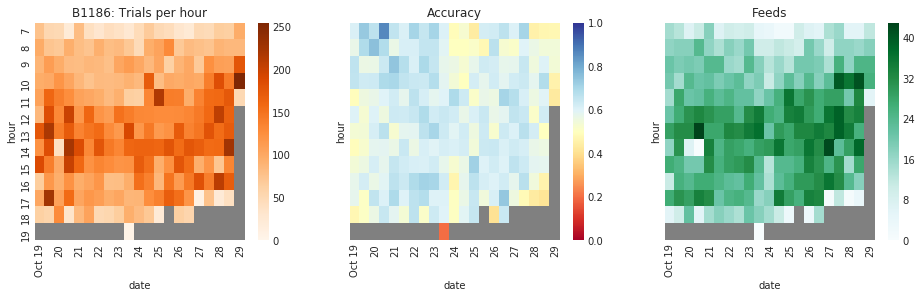

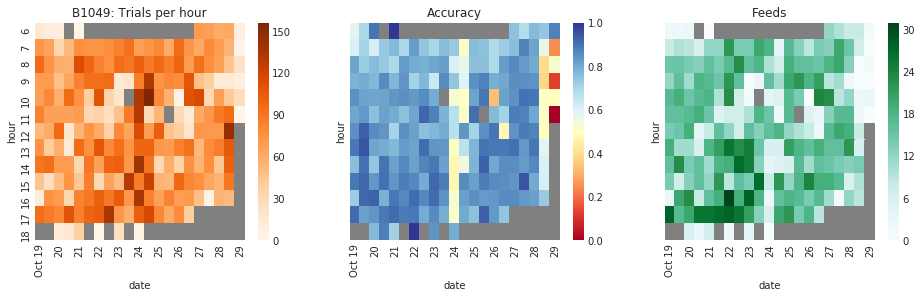

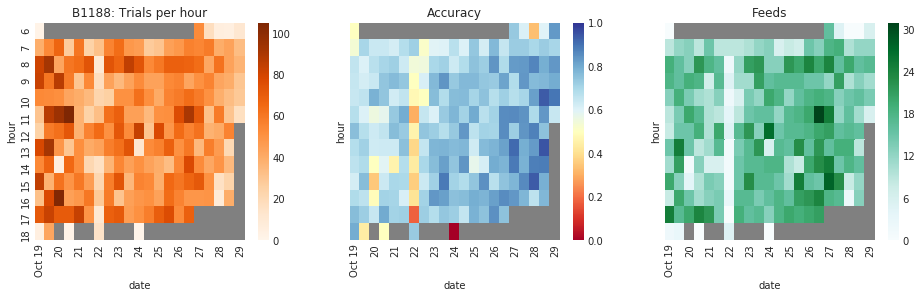

In [3]:
for subj,data in behav_data.items():
    pc_fig = plotting.plot_filtered_performance_calendar(subj, data, num_days=20)

## Plot percent correct by block with confidence bounds

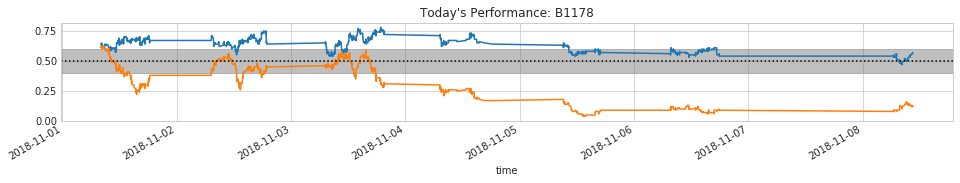

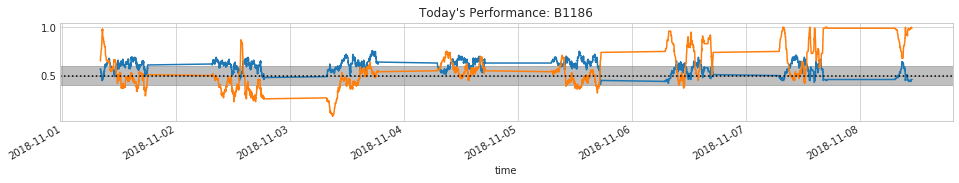

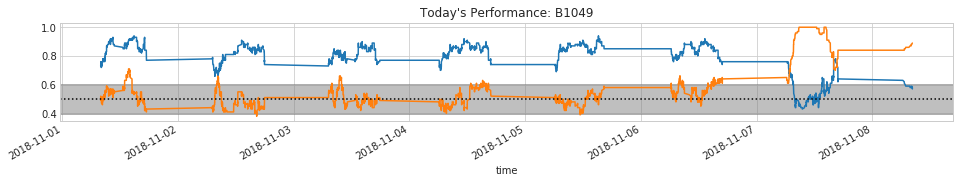

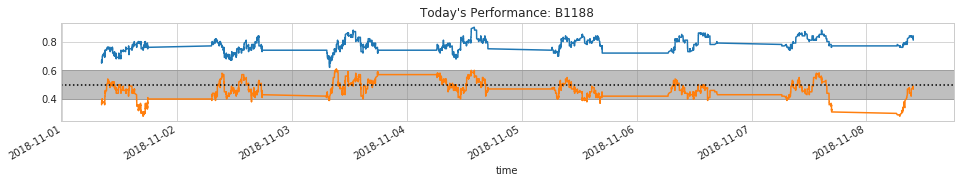

In [4]:
for subj,df in behav_data.items():
    ci_acc_fig =  plotting.plot_ci_accuracy(subj, df)

### plot accuracy today

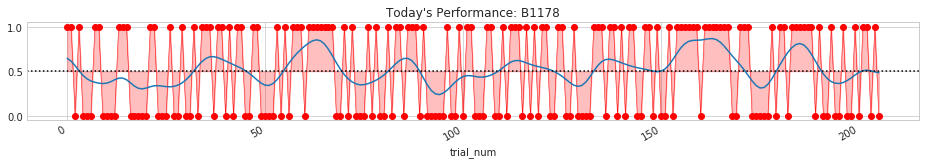

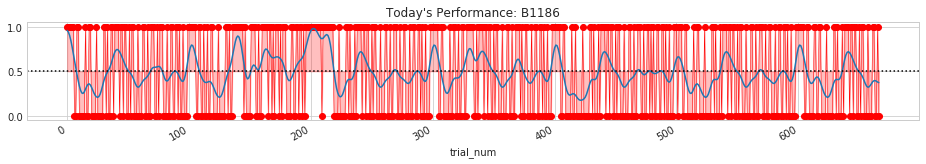

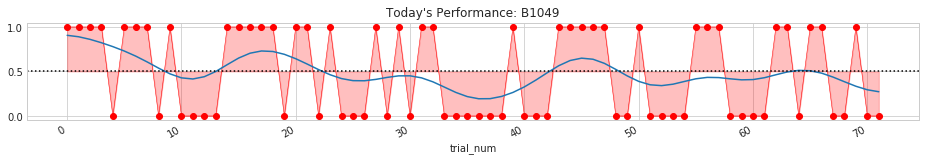

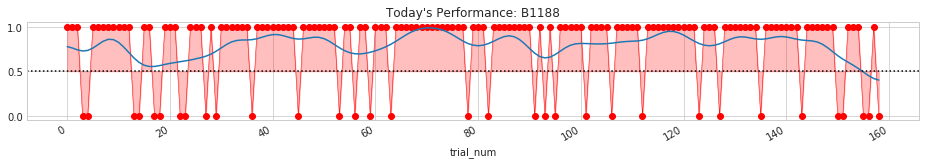

In [5]:
for subj,df in behav_data.items():
    daily_acc_fig = plotting.plot_daily_accuracy(subj, df, x_axis='trial_num')

# Plot number of trials and feeds for past week

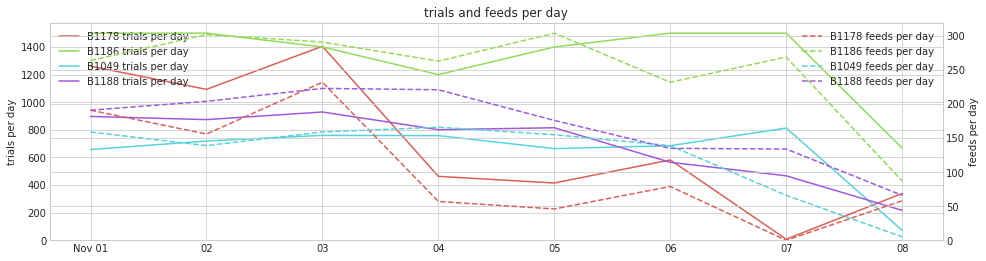

In [6]:
trial_feeds_fig = plotting.plot_trial_feeds(behav_data)